<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Basic_resnet_explorationTPU_failedtraining_pretrained_true.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install fastai2 from github

In [1]:
!pip install -Uqq fastcore --upgrade
!pip install -Uqq fastai --upgrade 
!pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions

     |████████████████████████████████| 358kB 3.3MB/s 


In [2]:
VERSION = "20200707"  #"20200515" @param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  32169      0 --:--:-- --:--:-- --:--:-- 32169


In [3]:
#!TORCH_SHOW_CPP_STACKTRACES=1 python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
!python pytorch-xla-env-setup.py  --version $VERSION --apt-packages libomp5 libopenblas-dev

Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200707 ...
     |████████████████████████████████| 61kB 2.5MB/s 
Uninstalling torch-1.6.0+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.6.0+cu101
Uninstalling torchvision-0.7.0+cu101:
  Successfully uninstalled torchvision-0.7.0+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
- [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
\ [1 files][123.8 MiB/123.8 MiB]                                                
Operation completed over 1 objects/123.8 MiB.                     

In [4]:
!pip freeze | grep torch 
!pip freeze | grep fastcore
!pip freeze | grep fastai

torch==1.7.0a0+12b5bdc
torch-xla==1.6+5430aca
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.0a0+86b6c3e
fastcore==1.0.0
fastai==2.0.0
fastai-xla-extensions==0.0.1


In [1]:
import fastai_xla_extensions.core

In [2]:
from fastai.vision.all import *

In [3]:
from fastai_xla_extensions.core import default_device, to_device

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path; path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

# Load in TPU

In [5]:
dblock = DataBlock(
    splitter = GrandparentSplitter(),
    item_tfms = Resize(28),
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    batch_tfms = []
)


In [6]:
dls_tpu = dblock.dataloaders(path, device=default_device())
dls_tpu.device

device(type='xla', index=1)

In [7]:
tpu_learner = cnn_learner(dls_tpu, resnet18, pretrained=True, metrics=accuracy)

In [8]:
tpu_learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

In [9]:
tpu_learner.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, XLAOptCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch 

# Call fit

Will fail in `self.loss.backward(); `?

In [10]:
tpu_learner.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.137379,0.833501,0.585868,00:23


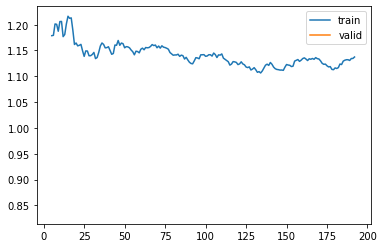

In [11]:
tpu_learner.recorder.plot_loss()

In [13]:
tpu_learner.unfreeze()

In [14]:
%%time
tpu_learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.121667,0.840853,0.580962,00:23


CPU times: user 7.11 s, sys: 876 ms, total: 7.99 s
Wall time: 23.6 s


In [15]:
tpu_learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.119356,0.845768,0.577036,00:21
1,1.108155,0.823684,0.582434,00:21
2,1.143584,0.835649,0.589303,00:21
3,1.112138,0.856550,0.574583,00:21
4,1.103486,0.843878,0.578999,00:21
5,1.108675,0.857935,0.571148,00:23
6,1.139158,0.836596,0.580962,00:21
7,1.126376,0.846665,0.583415,00:21
8,1.141315,0.837974,0.578508,00:21
9,1.119917,0.826240,0.581943,00:20


In [22]:
class DeviceCheckCallback(Callback):
    
    def after_pred(self):
        print(f'xb device: {first(self.learn.xb).device}')
        print(f'model device: {one_param(self.learn.model).device}')


In [23]:
tpu_learner.fit_one_cycle(1, cbs=[DeviceCheckCallback()])

epoch,train_loss,valid_loss,accuracy,time
0,0.019918,0.005847,0.998037,00:26


xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
x